In [254]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, List, Tuple
from pprint import pprint
from tqdm import tqdm
import time
from scipy import stats
from scipy.optimize import minimize

from itertools import combinations

import missingno as msno
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import BaseEstimator, TransformerMixin

from BorutaShap import BorutaShap
import category_encoders as ce

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool, EFeaturesSelectionAlgorithm, EShapCalcType
import xgboost as xgb

import optuna
from optuna.samplers import TPESampler

from utils import *
import gc
gc.enable()

In [2]:
seed = 42
np.random.seed(seed)
np.set_printoptions(2)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

ID_COL = 'APPLICATION_NUMBER'
TARGET= 'TARGET'

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [39]:
data = pd.concat([train, test], axis=0)
df = prepare_cp_sec(data, dropna=True, create_features=True, is_category_encode=False)

df_cat_cols = [column for column in df.columns if df[column].dtype in ["object", "category"]]
for col in df_cat_cols:
    if df[col].nunique() > 20:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col].astype(str).fillna("NA"))
df, _ = get_encoded(df)

data_border = len(df) - df[TARGET].isna().sum()
data_train, data_test = df.iloc[:data_border, :], df.iloc[data_border:, :]

bureau = bki_cr()

X, y = data_train.drop(TARGET, axis=1), data_train[TARGET]
X = X.merge(bureau, on=ID_COL, how='left')
X_index = X[ID_COL]
X = X.drop(ID_COL, axis=1)

data_test.drop(TARGET, axis=1, inplace=True)
data_test = data_test.merge(bureau, on=ID_COL, how='left')
test_index = data_test[ID_COL]
data_test.drop(ID_COL, axis=1, inplace=True)

X.reset_index(drop=True, inplace=True)
X.shape, data_test.shape

Memory usage of dataframe is 182.15 MB
Memory usage after optimization is: 90.60 MB
Decreased by 50.3%


((89539, 151), (134175, 151))

In [50]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=10000, shuffle=True, random_state=seed)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
x_test.shape

(10000, 151)

In [31]:
X_inspect = pd.concat([x_train, x_test], axis=0)
y_inspect = np.hstack((np.ones(x_train.shape[0]), np.zeros(x_test.shape[0])))

inspector = LGBMClassifier(max_depth=3, 
                           n_estimators=100,
                           verbose=-1,
                           is_unbalance=True,
                           learning_rate=0.08,   
                           random_seed=seed).fit(X_inspect, y_inspect)

cv = cross_val_score(
                     estimator=inspector,
                     X=X_inspect, 
                     y=y_inspect,
                     scoring="roc_auc",
                     cv=KFold(n_splits=5, shuffle=True, random_state=seed)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.5001


In [ ]:
lgbm_params = {
                'metric':"auc", 
                'boosting_type': 'goss',
                'is_unbalance': True,
                'n_estimators': 212, 
                'learning_rate': 0.01, 
                'min_child_weight': 350, 
                'min_split_gain': 0.024766,
                'max_depth': 3,
                'verbose': -1,
                'reg_alpha': 30,
                'reg_lambda': 30,
                'colsample_bytree': 0.33,
                'num_leaves': 42,
                'subsample': 0.33,
                'max_bin': 128,
                'random_state': seed
}

selector = BorutaShap(model=LGBMClassifier(**lgbm_params), importance_measure='shap', classification=True)
selector.fit(x_train, y_train, n_trials=20, sample=False, normalize=True, verbose=True)

In [33]:
boruta = ['EXT_SCORES_var', 'NAME_CONTRACT_TYPE', 'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'EXT_SCORES_max', 
          'RATIO_CREDIT_TO_AGE', 'EXT_SCORE_3_ANNUITY', 'RATIO_AGE_TO_EXPERIENCE', 'AGE', 'EXT_SCORE_1_AMT_CREDIT', 
          'EXTERNAL_SCORING_RATING_3', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'EXTERNAL_SCORING_RATING_1', 'AGE_BIN', 'CREDIT_JOB', 
          'DAYS_ON_LAST_JOB', 'EXT_SCORES_mean', 'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 'RATIO_AMOUNT_ANNUITY_TO_SALARY', 
          'TOTAL_SALARY_MEAN_BY_EDUCATION', 'EXT_SCORE_2_AMT_CREDIT', 'GENDER', 'TOTAL_SALARY_MIN_BY_EDUCATION', 
          'AMOUNT_ANNUITY', 'ANNUITY_JOB', 'AMOUNT_ANNUITY_MAX_BY_EDUCATION', 'EXTERNAL_SCORE_WEIGHTED', 
          'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'OWN_CAR_AGE', 'EXT_SCORE_2_ANNUITY', 'AMOUNT_ANNUITY_MIN_BY_EDUCATION', 
          'RATIO_CAR_TO_AGE', 'EXT_SCORES_min', 'EXT_SCORES_nanmedian', 'EXTERNAL_SCORING_RATING_2', 
          'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'EDUCATION_FAMILY_STATUS', 'NEW_CREDIT_TO_ANNUITY_RATIO', 
          'EXT_SCORE_3_AMT_CREDIT', 'RATIO_ANNUITY_TO_AGE', 'EDUCATION_LEVEL_Secondary / secondary special', 
          'AMOUNT_CREDIT_COUNT_BY_EDUCATION', 'EDUCATION_LEVEL_Higher education', 'RATIO_SALARY_TO_AMOUNT_CREDIT', 
          'SALARY_JOB', 'NEW_STATUS_FMarried', 'REGION_POPULATION', 'AMT_REQ_CREDIT_BUREAU_QRT', 
          'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY', 'TOTAL_SALARY_MEAN_AGE_INTERVAL', 'AMOUNT_CREDIT_MAX_BY_EDUCATION', 
          'AMOUNT_CREDIT_COUNT_AGE_INTERVAL', 'AMOUNT_CREDIT', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'RATIO_SALARY_TO_AGE', 
          'EXT_SCORE_1_ANNUITY', 'TOTAL_SALARY_COUNT_AGE_INTERVAL', 'AMOUNT_ANNUITY_COUNT_AGE_INTERVAL', 
          'SALARY_REGION_POPULATION', 'AMOUNT_ANNUITY_COUNT_BY_EDUCATION', 'RATIO_CAR_TO_EXPERIENCE']

In [80]:
lgbm_params1 = {
                'metric':"auc", 
                'boosting_type': 'gbdt',
                'n_estimators': 1000,
                'learning_rate': 0.035,
                'num_leaves': 12,
                'max_depth': 12,
                'reg_alpha': 0.05,
                'reg_lambda': 0.06,
                'subsample': 0.8,
                'min_child_weight': 56,
                'random_state': seed,
                'zero_as_missing': False
}

estimators_lgbm1, oof_preds_lgbm1 = lightgbm_cross_validation(lgbm_params1, 
                                                              x_train[boruta], 
                                                              y_train, 
                                                              cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                              rounds=50)

Sun Aug 28 15:52:37 2022, Cross-Validation, 79539 rows, 60 cols
Fold 1, Train score = 0.80430, Valid score = 0.74063
Fold 2, Train score = 0.78733, Valid score = 0.75802
Fold 3, Train score = 0.80481, Valid score = 0.76250
Fold 4, Train score = 0.80137, Valid score = 0.75706
Fold 5, Train score = 0.78996, Valid score = 0.76161
Train score by each fold: [0.8043, 0.78733, 0.80481, 0.80137, 0.78996]
Valid score by each fold: [0.74063, 0.75802, 0.7625, 0.75706, 0.76161]
Train mean score by each fold:0.79755 +/- 0.00742
Valid mean score by each fold:0.75596 +/- 0.00794
**************************************************
OOF-score: 0.75596


In [81]:
preds = np.array([estimator.predict_proba(x_test[boruta])[:,1] for estimator in estimators_lgbm1]).T
# preds = np.mean(preds, axis=1)
preds = stats.gmean(preds, axis=1)
roc_auc_score(y_test, preds)

0.7569927989130436

In [82]:
calculate_confidence_interval(create_bootstrap_metrics(y_test, preds, roc_auc_score))

(0.7394677882461692, 0.7738677300013224)

In [83]:
# obtain CV estimators from full dataset after HO check
estimators_lgbm1, oof_preds_lgbm1 = lightgbm_cross_validation(lgbm_params1, 
                                                              X[boruta], 
                                                              y.reset_index(drop=True), 
                                                              cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                              rounds=50)

Sun Aug 28 15:53:12 2022, Cross-Validation, 89539 rows, 60 cols
Fold 1, Train score = 0.79869, Valid score = 0.75708
Fold 2, Train score = 0.79305, Valid score = 0.75414
Fold 3, Train score = 0.80603, Valid score = 0.75727
Fold 4, Train score = 0.79681, Valid score = 0.75590
Fold 5, Train score = 0.78148, Valid score = 0.75683
Train score by each fold: [0.79869, 0.79305, 0.80603, 0.79681, 0.78148]
Valid score by each fold: [0.75708, 0.75414, 0.75727, 0.7559, 0.75683]
Train mean score by each fold:0.79521 +/- 0.00806
Valid mean score by each fold:0.75624 +/- 0.00115
**************************************************
OOF-score: 0.75617


In [84]:
test_preds = np.array([model.predict_proba(data_test[boruta])[:,1] for model in estimators_lgbm1]).T
# test_preds1 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.mean(axis=1)})
# test_preds1 = test_preds.mean(axis=1)
test_preds1 = stats.gmean(test_preds, axis=1)

**LGBM with exhustive**

In [220]:
exhaust = ['NAME_CONTRACT_TYPE', 'RATIO_CREDIT_TO_AGE', 'EXT_SCORE_3_ANNUITY',  'AGE', 'EXTERNAL_SCORING_RATING_3', 
           'AMT_REQ_CREDIT_BUREAU_YEAR', 'EXTERNAL_SCORING_RATING_1', 'EXT_SCORES_mean', 'RATIO_AMOUNT_ANNUITY_TO_SALARY', 
           'GENDER', 'AMOUNT_ANNUITY', 'ANNUITY_JOB', 'RATIO_CAR_TO_AGE', 'EXT_SCORES_min', 
           'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'EDUCATION_FAMILY_STATUS', 'NEW_CREDIT_TO_ANNUITY_RATIO',
           'EXT_SCORE_3_AMT_CREDIT', 'SALARY_JOB', 'REGION_POPULATION']

In [223]:
lgbm_params2 = {
                'metric':"auc", 
                'boosting_type': 'gbdt',
                'n_estimators': 2000,
                'learning_rate': 0.035,
                'num_leaves': 12,
                'max_depth': 8,
                'reg_alpha': 0.05,
                'reg_lambda': 0.06,
                'subsample': 0.8,
                'min_child_weight': 56,
                'colsample_bytree': 0.67,
                'max_bin': 255,
                'is_unbalance': False,
                'random_state': seed,
                'zero_as_missing': True,
                'min_split_gain': 0.024766,
                'subsample_for_bin': 240000,
                
}


estimators_lgbm2, oof_preds_lgbm2 = lightgbm_cross_validation(lgbm_params2, 
                                                              x_train[exhaust], 
                                                              y_train, 
                                                              cv=KFold(n_splits=7, random_state=seed, shuffle=True), 
                                                              rounds=50)

Sun Aug 28 21:44:52 2022, Cross-Validation, 79539 rows, 20 cols
Fold 1, Train score = 0.80468, Valid score = 0.74794
Fold 2, Train score = 0.80378, Valid score = 0.74181
Fold 3, Train score = 0.78105, Valid score = 0.77163
Fold 4, Train score = 0.81417, Valid score = 0.77234
Fold 5, Train score = 0.80722, Valid score = 0.76203
Fold 6, Train score = 0.78740, Valid score = 0.76456
Fold 7, Train score = 0.79774, Valid score = 0.75979
Train score by each fold: [0.80468, 0.80378, 0.78105, 0.81417, 0.80722, 0.7874, 0.79774]
Valid score by each fold: [0.74794, 0.74181, 0.77163, 0.77234, 0.76203, 0.76456, 0.75979]
Train mean score by each fold:0.79943 +/- 0.01076
Valid mean score by each fold:0.76001 +/- 0.01062
**************************************************
OOF-score: 0.75984


In [224]:
preds = np.array([estimator.predict_proba(x_test[exhaust])[:,1] for estimator in estimators_lgbm2]).T
# preds = np.mean(preds, axis=1)
preds = stats.gmean(preds, axis=1)
roc_auc_score(y_test, preds)

0.7573384510869565

In [225]:
calculate_confidence_interval(create_bootstrap_metrics(y_test, preds, roc_auc_score))

(0.7409764628349254, 0.775147742457603)

In [226]:
estimators_lgbm2, oof_preds_lgbm2 = lightgbm_cross_validation(lgbm_params2, 
                                                              X[exhaust], 
                                                              y.reset_index(drop=True), 
                                                              cv=KFold(n_splits=7, random_state=seed//3, shuffle=True), 
                                                              rounds=50)

Sun Aug 28 21:45:09 2022, Cross-Validation, 89539 rows, 20 cols
Fold 1, Train score = 0.80237, Valid score = 0.75214
Fold 2, Train score = 0.79580, Valid score = 0.76570
Fold 3, Train score = 0.79613, Valid score = 0.75690
Fold 4, Train score = 0.79688, Valid score = 0.75790
Fold 5, Train score = 0.79248, Valid score = 0.76615
Fold 6, Train score = 0.79461, Valid score = 0.76985
Fold 7, Train score = 0.79997, Valid score = 0.75640
Train score by each fold: [0.80237, 0.7958, 0.79613, 0.79688, 0.79248, 0.79461, 0.79997]
Valid score by each fold: [0.75214, 0.7657, 0.7569, 0.7579, 0.76615, 0.76985, 0.7564]
Train mean score by each fold:0.79689 +/- 0.00307
Valid mean score by each fold:0.76072 +/- 0.00601
**************************************************
OOF-score: 0.76040


In [227]:
test_preds = np.array([model.predict_proba(data_test[exhaust])[:,1] for model in estimators_lgbm2]).T
# test_preds2 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.mean(axis=1)})
# test_preds2 = test_preds.mean(axis=1)
test_preds2 = stats.gmean(test_preds, axis=1)

In [228]:
pd.DataFrame({'m1': test_preds1, 'm2': test_preds2}).corr()  # not good: need <=0.97

,m1,m2
m1,1.0000,0.9866
m2,0.9866,1.0000


**CatBoost**

In [ ]:
# boruta catboost
cat_params = {
                'silent': True,  
                'one_hot_max_size': 2,  
                'iterations': 255, 
                'eval_metric': 'AUC',  
                'allow_writing_files': False,  
                'random_seed': seed,  
                'grow_policy': 'Lossguide', 
                'objective': 'Logloss',  
                'boosting_type': 'Plain', 
                'score_function': 'Cosine',  
                'bootstrap_type': 'MVS',  
                'bagging_temperature': 3.68,  
                'colsample_bylevel': 0.9,  
                'depth': 3, 
                'l2_leaf_reg': 3,  
                'learning_rate': 0.05, 
                'subsample': 0.86,  
                'num_leaves': 32
}

selector = BorutaShap(model=CatBoostClassifier(**cat_params), importance_measure='shap', classification=True)
selector.fit(x_train, y_train, n_trials=20, sample=False, normalize=True, verbose=True)

In [268]:
boruta = ['GENDER', 'EXT_SCORES_nanmedian', 'EXT_SCORES_min', 'AGE', 'EXTERNAL_SCORING_RATING_3', 'NAME_CONTRACT_TYPE', 
          'EXTERNAL_SCORING_RATING_1', 'ANNUITY_JOB', 'CREDIT_JOB', 'EXTERNAL_SCORE_WEIGHTED', 'EXT_SCORES_max', 
          'EXT_SCORES_mean', 'RATIO_CREDIT_TO_AGE', 'NEW_CREDIT_TO_ANNUITY_RATIO', 'RATIO_AMOUNT_ANNUITY_TO_SALARY', 
          'RATIO_AGE_TO_EXPERIENCE', 'EXT_SCORES_var', 'TOTAL_SALARY_MAX_BY_EDUCATION', 
          'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'RATIO_ANNUITY_TO_AGE', 'DAYS_ON_LAST_JOB', 'SALARY_JOB', 
          'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 'TOTAL_SALARY_MEAN_BY_EDUCATION', 'AMT_REQ_CREDIT_BUREAU_QRT', 
          'TOTAL_SALARY_MIN_BY_EDUCATION', 'AMOUNT_ANNUITY', 'AMOUNT_ANNUITY_MAX_BY_EDUCATION', 'NEW_STATUS_MCivil marriage', 
          'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'OWN_CAR_AGE', 'EXT_SCORE_2_ANNUITY', 'AMOUNT_CREDIT_MAX_BY_EDUCATION', 
          'AMOUNT_ANNUITY_MIN_BY_EDUCATION', 'AMOUNT_CREDIT_COUNT_AGE_INTERVAL', 'RATIO_CAR_TO_AGE', 
          'EXTERNAL_SCORING_RATING_2', 'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'EDUCATION_FAMILY_STATUS', 
          'AMOUNT_ANNUITY_COUNT_AGE_INTERVAL', 'RATIO_CAR_TO_EXPERIENCE', 'EXT_SCORE_3_AMT_CREDIT', 'AGE_BIN']

In [269]:
cat_params = {
                'silent': True,  
                'iterations': 2000, 
                'eval_metric': 'AUC',  
                'allow_writing_files': False,  
                'random_seed': seed,  
                'grow_policy': 'Lossguide', 
                'boosting_type': 'Plain', 
                'bootstrap_type': 'MVS',  
                'bagging_temperature': 3.68,  
                'colsample_bylevel': 0.9,  
                'depth': 8, 
                'l2_leaf_reg': 3,  
                'learning_rate': 0.05, 
                'subsample': 0.86,  
                'num_leaves': 12,
                'use_best_model': True,
                'min_data_in_leaf': 100,
}

estimators_cat1, oof_preds_cat1 = catboost_cross_validation(cat_params, 
                                                            x_train[boruta], 
                                                            y_train, 
                                                            cv=KFold(n_splits=7, random_state=seed, shuffle=True), 
                                                            rounds=50)

Sun Aug 28 23:46:41 2022, Cross-Validation, 79539 rows, 43 cols
Fold 1, Train score = 0.83240, Valid score = 0.74053
Fold 2, Train score = 0.85262, Valid score = 0.73531
Fold 3, Train score = 0.84183, Valid score = 0.77143
Fold 4, Train score = 0.85164, Valid score = 0.76202
Fold 5, Train score = 0.85711, Valid score = 0.75789
Fold 6, Train score = 0.83513, Valid score = 0.75818
Fold 7, Train score = 0.83048, Valid score = 0.75894
Train score by each fold: [0.8324, 0.85262, 0.84183, 0.85164, 0.85711, 0.83513, 0.83048]
Valid score by each fold: [0.74053, 0.73531, 0.77143, 0.76202, 0.75789, 0.75818, 0.75894]
Train mean score by each fold:0.84303 +/- 0.00999
Valid mean score by each fold:0.75490 +/- 0.01165
**************************************************
OOF-score: 0.75482


In [272]:
preds = np.array([estimator.predict_proba(x_test[boruta])[:,1] for estimator in estimators_cat1]).T
preds = stats.gmean(preds, axis=1)
roc_auc_score(y_test, preds)

0.7581605978260869

In [273]:
calculate_confidence_interval(create_bootstrap_metrics(y_test, preds, roc_auc_score))

(0.7402246159404027, 0.7743613008383707)

In [275]:
estimators_cat1, oof_preds_cat1 = catboost_cross_validation(cat_params, 
                                                            X[boruta], 
                                                            y.reset_index(drop=True), 
                                                            cv=KFold(n_splits=7, random_state=seed, shuffle=True), 
                                                            rounds=50)

Sun Aug 28 23:54:30 2022, Cross-Validation, 89539 rows, 43 cols
Fold 1, Train score = 0.84548, Valid score = 0.76057
Fold 2, Train score = 0.82765, Valid score = 0.74232
Fold 3, Train score = 0.82625, Valid score = 0.76140
Fold 4, Train score = 0.83147, Valid score = 0.75385
Fold 5, Train score = 0.83014, Valid score = 0.75700
Fold 6, Train score = 0.81945, Valid score = 0.75743
Fold 7, Train score = 0.83253, Valid score = 0.75842
Train score by each fold: [0.84548, 0.82765, 0.82625, 0.83147, 0.83014, 0.81945, 0.83253]
Valid score by each fold: [0.76057, 0.74232, 0.7614, 0.75385, 0.757, 0.75743, 0.75842]
Train mean score by each fold:0.83042 +/- 0.00735
Valid mean score by each fold:0.75586 +/- 0.00598
**************************************************
OOF-score: 0.75580


In [277]:
test_preds = np.array([model.predict_proba(data_test[boruta])[:,1] for model in estimators_cat1]).T

test_preds3 = stats.gmean(test_preds, axis=1)

In [278]:
pd.DataFrame({'m1': test_preds1, 'm2': test_preds2, 'm3': test_preds3}).corr()

,m1,m2,m3
m1,1.0000,0.9866,0.9760
m2,0.9866,1.0000,0.9700
m3,0.9760,0.9700,1.0000


#### XGBoost

In [ ]:
# boruta xgboost
xgb_params = {
                "objective": "binary:logistic",
                "booster": "gbtree",
                "eval_metric": "auc",
                "n_estimators": 250,
                "eta": 0.05,
                "max_depth": 4,
                "gamma": 10,
                "subsample": 0.85,
                "colsample_bytree": 0.7,
                "colsample_bylevel": 0.632,
                "min_child_weight": 30,
                "alpha": 0.05,
                "lambda": 0.067,
                "random_state": seed,
}

selector = BorutaShap(model=xgb.XGBClassifier(**xgb_params), importance_measure='shap', classification=True)
selector.fit(x_train, y_train, n_trials=20, sample=False, normalize=True, verbose=True)

In [280]:
boruta = ['NAME_CONTRACT_TYPE', 'EXT_SCORES_max', 'RATIO_CREDIT_TO_AGE', 'RATIO_AGE_TO_EXPERIENCE', 'AGE', 
          'EXTERNAL_SCORING_RATING_3', 'EXTERNAL_SCORING_RATING_1', 'DAYS_ON_LAST_JOB', 'EXT_SCORES_mean', 
          'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'GENDER', 'ANNUITY_JOB', 'EXTERNAL_SCORE_WEIGHTED', 'OWN_CAR_AGE', 
          'EXT_SCORES_nanmedian', 'EXT_SCORES_min', 'RATIO_CAR_TO_AGE', 'EXTERNAL_SCORING_RATING_2', 
          'EDUCATION_FAMILY_STATUS', 'NEW_CREDIT_TO_ANNUITY_RATIO', 'AMT_REQ_CREDIT_BUREAU_QRT', 
          'TOTAL_SALARY_MIN_BY_EDUCATION', 'AMOUNT_ANNUITY', 'CREDIT_JOB', 'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 
          'TOTAL_SALARY_MEAN_BY_EDUCATION', 'RATIO_ANNUITY_TO_AGE']

In [283]:
xgb_params = {
                "objective": "binary:logistic",
                "booster": "gbtree",
                "eval_metric": "auc",
                "eta": 0.05,
                "max_depth": 6,
                "gamma": 10,
                "subsample": 0.85,
                "colsample_bytree": 0.7,
                "colsample_bylevel": 0.632,
                "min_child_weight": 30,
                "alpha": 0.05,
                "lambda": 0.067,
                "random_state": seed,
                "n_jobs": -1
}

In [284]:
estimators_xgb, _, oof_preds_xgb = xgboost_cross_validation(xgb_params, 
                                                            x_train[boruta], 
                                                            y_train, 
                                                            cv=KFold(n_splits=7, random_state=seed, shuffle=True), 
                                                            rounds=50)

Mon Aug 29 00:08:05 2022, Cross-Validation, 79539 rows, 27 cols
Fold 1, Train score = 0.80456, Valid score = 0.74666
Fold 2, Train score = 0.80158, Valid score = 0.74008
Fold 3, Train score = 0.78807, Valid score = 0.76917
Fold 4, Train score = 0.79592, Valid score = 0.76667
Fold 5, Train score = 0.80025, Valid score = 0.76294
Fold 6, Train score = 0.79068, Valid score = 0.76337
Fold 7, Train score = 0.79174, Valid score = 0.76126
Train score by each fold: [0.80456, 0.80158, 0.78807, 0.79592, 0.80025, 0.79068, 0.79174]
Valid score by each fold: [0.74666, 0.74008, 0.76917, 0.76667, 0.76294, 0.76337, 0.76126]
Train mean score by each fold:0.79611 +/- 0.00575
Valid mean score by each fold:0.75859 +/- 0.01008
**************************************************
OOF-score: 0.75846


In [287]:
preds = np.array([estimator.predict(xgb.DMatrix(x_test[boruta])) for estimator in estimators_xgb]).T
preds = stats.gmean(preds, axis=1)
roc_auc_score(y_test, preds)

0.7584173913043478

In [288]:
calculate_confidence_interval(create_bootstrap_metrics(y_test, preds, roc_auc_score))

(0.741429045334615, 0.7745216898698617)

In [289]:
estimators_xgb, _, oof_preds_xgb = xgboost_cross_validation(xgb_params, 
                                                            X[boruta], 
                                                            y.reset_index(drop=True), 
                                                            cv=KFold(n_splits=7, random_state=seed, shuffle=True), 
                                                            rounds=50)

Mon Aug 29 00:12:26 2022, Cross-Validation, 89539 rows, 27 cols
Fold 1, Train score = 0.80057, Valid score = 0.76509
Fold 2, Train score = 0.79554, Valid score = 0.74509
Fold 3, Train score = 0.79347, Valid score = 0.76817
Fold 4, Train score = 0.79275, Valid score = 0.75790
Fold 5, Train score = 0.79405, Valid score = 0.75977
Fold 6, Train score = 0.79449, Valid score = 0.76123
Fold 7, Train score = 0.79654, Valid score = 0.75923
Train score by each fold: [0.80057, 0.79554, 0.79347, 0.79275, 0.79405, 0.79449, 0.79654]
Valid score by each fold: [0.76509, 0.74509, 0.76817, 0.7579, 0.75977, 0.76123, 0.75923]
Train mean score by each fold:0.79534 +/- 0.00243
Valid mean score by each fold:0.75950 +/- 0.00676
**************************************************
OOF-score: 0.75947


In [293]:
xgb_data_test = data_test[boruta].copy(deep=True)

for col in xgb_data_test.columns:
    xgb_data_test[col] = xgb_data_test[col].replace(np.inf, 0)

In [294]:
test_preds = np.array([model.predict(xgb.DMatrix(xgb_data_test)) for model in estimators_xgb]).T

test_preds4 = stats.gmean(test_preds, axis=1)

In [296]:
pd.DataFrame({'lgbm': test_preds1, 'lgbm2': test_preds2, 'cat': test_preds3, 'xgb': test_preds4}).corr()

,lgbm,lgbm2,cat,xgb
lgbm,1.0000,0.9866,0.9760,0.9903
lgbm2,0.9866,1.0000,0.9700,0.9830
cat,0.9760,0.9700,1.0000,0.9802
xgb,0.9903,0.9830,0.9802,1.0000


### Averaging

In [297]:
oof_predictions = pd.DataFrame(data={'m1': oof_preds_lgbm1, 'm2': oof_preds_lgbm2, 'm3': oof_preds_cat1, 'm4': oof_preds_xgb})
test_predictions = pd.DataFrame(data={'m1': test_preds1, 'm2': test_preds2, 'm3': test_preds3, 'm4': test_preds4})

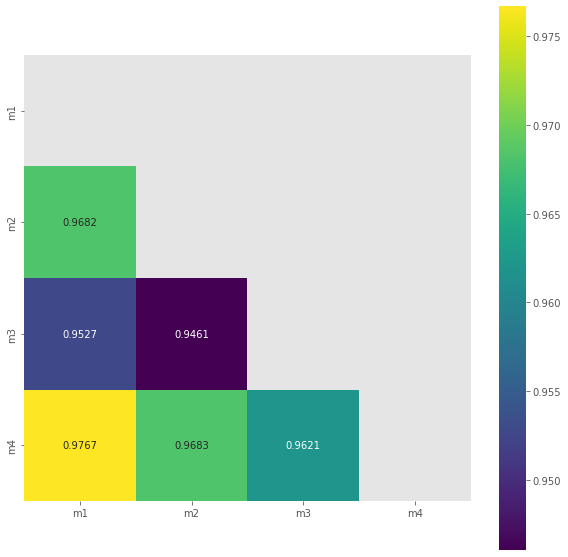

In [298]:
corr = oof_predictions.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)
plt.show()

In [299]:
mean_scores(oof_predictions, y)

AMean score: 0.76046
GMean score: 0.76051
Rank  score: 0.76049
GMean  rank: 0.76050


In [301]:
lda = LinearDiscriminantAnalysis(
                                 solver='eigen',  
                                 shrinkage='auto',
                                 store_covariance=True,
                                 n_components=1
                                )

estimators_lda, oof_preds_lda, mean_score = cross_validation(model=lda,
                                                             X=oof_predictions,
                                                             y=y.reset_index(drop=True),
                                                             cv=KFold(n_splits=10, shuffle=True, random_state=seed))

Fold 1, Train score: 0.76227, Valid score = 0.75547
Fold 2, Train score: 0.76103, Valid score = 0.76666
Fold 3, Train score: 0.76307, Valid score = 0.74825
Fold 4, Train score: 0.76037, Valid score = 0.77219
Fold 5, Train score: 0.76139, Valid score = 0.76309
Fold 6, Train score: 0.76200, Valid score = 0.75774
Fold 7, Train score: 0.76138, Valid score = 0.76363
Fold 8, Train score: 0.76159, Valid score = 0.76176
Fold 9, Train score: 0.76105, Valid score = 0.76602
Fold 10, Train score: 0.76172, Valid score = 0.75950
Train score by each fold: [0.76227, 0.76103, 0.76307, 0.76037, 0.76139, 0.762, 0.76138, 0.76159, 0.76105, 0.76172]
Valid score by each fold: [0.75547, 0.76666, 0.74825, 0.77219, 0.76309, 0.75774, 0.76363, 0.76176, 0.76602, 0.7595]
Train mean score by each fold:0.76159 +/- 0.00071
Valid mean score by each fold:0.76143 +/- 0.00631
**************************************************


In [303]:
roc_auc_score(y, oof_preds_lda)

0.7614681110254293

In [305]:
test_fin = np.array([estimator.predict_proba(test_predictions)[:,1] for estimator in estimators_lda]).T
test_fin = pd.DataFrame(data=test_fin)
test_fin = stats.gmean(test_fin, axis=1)

In [308]:
# saving predicted scores to csv, columns: test_index, scores

final_predictions = pd.DataFrame({ID_COL: test_index, TARGET: test_fin})
final_predictions.to_csv('nonzero.csv', index=False)

### exhaustive selection

In [61]:
selector = BestSet(lgbm_params1, k_features=20).fit(x_train[boruta], y_train)  # boruta lgbm

In [63]:
x_train[boruta].columns[list(selector.subsets_[np.argmax(selector.scores_)])], max(selector.scores_)

(Index(['NAME_CONTRACT_TYPE', 'RATIO_CREDIT_TO_AGE', 'EXT_SCORE_3_ANNUITY',
        'AGE', 'EXTERNAL_SCORING_RATING_3', 'AMT_REQ_CREDIT_BUREAU_YEAR',
        'EXTERNAL_SCORING_RATING_1', 'EXT_SCORES_mean',
        'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'GENDER', 'AMOUNT_ANNUITY',
        'ANNUITY_JOB', 'RATIO_CAR_TO_AGE', 'EXT_SCORES_min',
        'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN',
        'EDUCATION_FAMILY_STATUS', 'NEW_CREDIT_TO_ANNUITY_RATIO',
        'EXT_SCORE_3_AMT_CREDIT', 'SALARY_JOB', 'REGION_POPULATION'],
       dtype='object'),
 0.7587457766304515)

In [ ]:
# optuna for every model